## Import Dependencies in Python

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
get_ipython().run_line_magic('matplotlib', 'inline')
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')
import datetime
import quandl
from plotnine import *
import plotly.graph_objects as go

## Getting WTI monthly data from QUANDL

In [2]:
WTI = quandl.get("FRED/DCOILWTICO", start_date="1990-01-01", end_date="2020-06-01",  authtoken="TYxF4cUU1kEsRwg8QEdu", collapse="monthly", order="asc")
print(WTI)
WTI.to_csv("WTI.csv")

            Value
Date             
1990-01-31  22.69
1990-02-28  21.55
1990-03-31  20.34
1990-04-30  18.50
1990-05-31  17.47
...           ...
2020-02-29  44.83
2020-03-31  20.51
2020-04-30  19.23
2020-05-31  35.57
2020-06-30  35.49

[366 rows x 1 columns]


## Getting BRENT monthly data from QUANDL

In [3]:
BRENT = quandl.get("FRED/DCOILBRENTEU", start_date="1990-01-01", end_date="2020-06-01",  authtoken="TYxF4cUU1kEsRwg8QEdu", collapse="monthly", order="asc")
print(BRENT)
BRENT.to_csv("BRENT.csv")

            Value
Date             
1990-01-31  20.50
1990-02-28  19.20
1990-03-31  17.95
1990-04-30  16.35
1990-05-31  15.30
...           ...
2020-02-29  51.31
2020-03-31  14.85
2020-04-30  18.11
2020-05-31  34.15
2020-06-30  36.74

[366 rows x 1 columns]


## Put WTI data into dataframe with dates as index

In [4]:
WTI_data = pd.read_csv('WTI.csv', parse_dates=['Date'], index_col='Date')
print (WTI_data.head())

            Value
Date             
1990-01-31  22.69
1990-02-28  21.55
1990-03-31  20.34
1990-04-30  18.50
1990-05-31  17.47


## Put BRENT data into dataframe with dates as index

In [5]:
BRENT_data = pd.read_csv('BRENT.csv', parse_dates=['Date'], index_col='Date')
print (BRENT_data.head())

            Value
Date             
1990-01-31  20.50
1990-02-28  19.20
1990-03-31  17.95
1990-04-30  16.35
1990-05-31  15.30


## Merge WTI and BRENT datasets into one dataset

In [6]:
oil_data=pd.merge(WTI_data,BRENT_data, on='Date',how='outer')
oil_data=oil_data.rename(columns={"Value_x": "WTI", "Value_y": "BRENT"})
oil_data

,WTI,BRENT
Date,,
1990-01-31,22.69,20.50
1990-02-28,21.55,19.20
1990-03-31,20.34,17.95
1990-04-30,18.50,16.35
1990-05-31,17.47,15.30
...,...,...
2020-02-29,44.83,51.31
2020-03-31,20.51,14.85
2020-04-30,19.23,18.11


## Check for Null Values and use a Forward Fill Resample Method to Fill in the Missing Values with Most Recent Value

In [7]:
oil_data.isnull().values.any()

False

In [8]:
oil_data = oil_data.fillna(method='ffill')

In [9]:
oil_data.isnull().values.any()

False

In [10]:
oil_data 

,WTI,BRENT
Date,,
1990-01-31,22.69,20.50
1990-02-28,21.55,19.20
1990-03-31,20.34,17.95
1990-04-30,18.50,16.35
1990-05-31,17.47,15.30
...,...,...
2020-02-29,44.83,51.31
2020-03-31,20.51,14.85
2020-04-30,19.23,18.11


## Step 1: Plot WTI and BRENT data for to visually inspect time series data

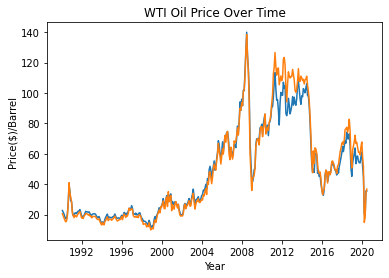

In [11]:
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.title('WTI Oil Price Over Time')
plt.plot(oil_data)
plt.rcParams["figure.figsize"] = [18,10]

In [12]:
WTI_ts=oil_data['WTI']
BRENT_ts=oil_data['BRENT']

# Step 2: Determine Whether Time Series Data are Stationary 
## Step 2a: Plot the rolling means and rolling standard deviations of time series data
#### The time series is stationary if the means and SD remain constant with time
## Step 2b: Test for Stationarity in the time series data using the Dickey-Fuller Test.
#### If the p-value for this test is > .05 on the test, we accept the null hypothesis and conclude the time series is not stationary. 
#### If the p-value  for this test is <= .05, we reject the null hypothesis and conclude the time series is stationary.
#### If the ADF Statistic is much lower than the critical values, that also confirms the time series is stationary.

In [13]:
def test_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.rcParams["figure.figsize"] = [18,10]
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

## Stationarity Tests

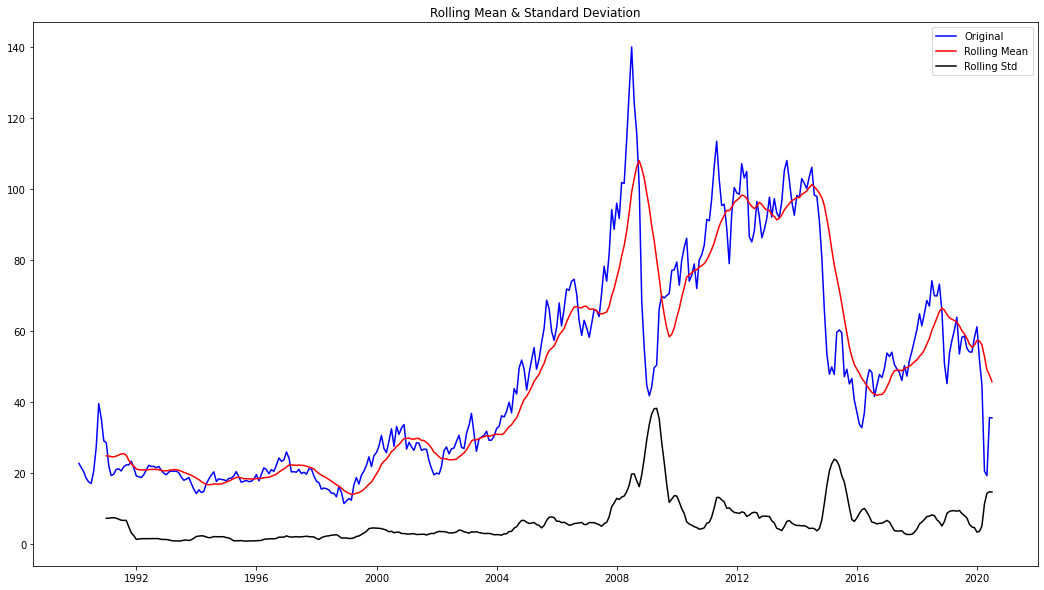

ADF Statistic: -2.242173001226864
p-value: 0.19129653045751677
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393


In [14]:
test_stationarity(WTI_ts)

### As we can see in the figure and Dickey Fuller test above, the WTI time series data are not stationary. The rolling mean and SD are not constant over time,  the WTI Dickey Fuller test is  > .05. Thus, we accept the null hypothesis and conclude the data is non-stationary.

## BRENT Stationarity Tests

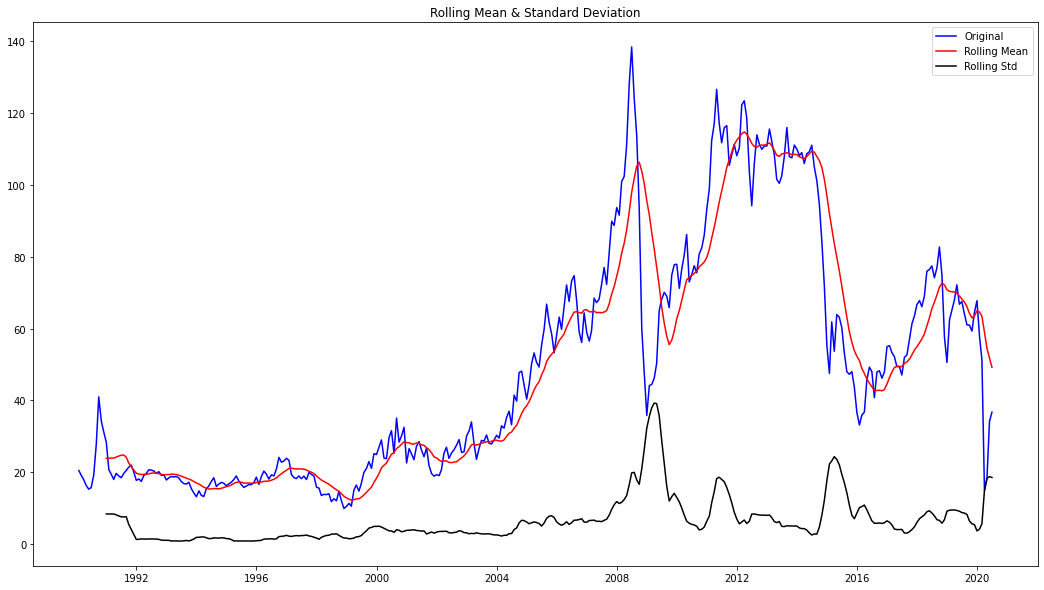

ADF Statistic: -2.204984301519695
p-value: 0.20444141916575137
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393


In [15]:
test_stationarity(BRENT_ts)

### As we can see in the figure and Dickey Fuller test above, the BRENT time series data are not stationary. The rolling mean and SD are not constant over time,  the WTI Dickey Fuller test is  > .05. Thus, we accept the null hypothesis and conclude the data is non-stationary.

## Differencing the Data - Transform the data 

In [16]:
WTI_log = np.log(WTI_ts)
BRENT_log = np.log(BRENT_ts)
WTI_log_diff = WTI_log - WTI_log.shift()
WTI_log_diff.dropna(inplace=True)
BRENT_log_diff = BRENT_log - BRENT_log.shift()
BRENT_log_diff.dropna(inplace=True)

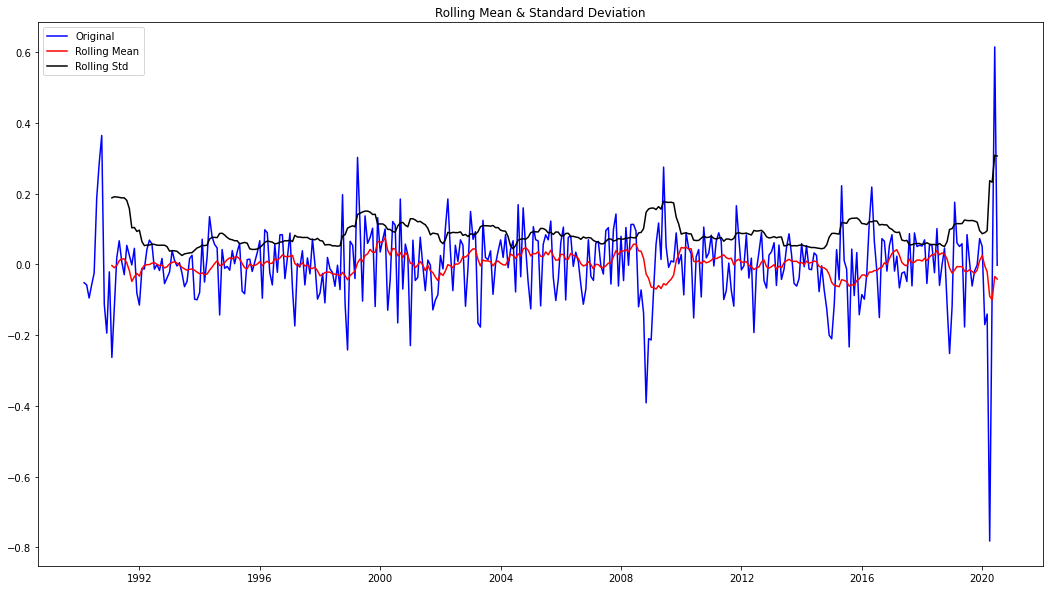

ADF Statistic: -8.695375340950026
p-value: 3.938069063496756e-14
Critical Values:
	1%: -3.448748905151901
	5%: -2.8696473721448728
	10%: -2.5710891239349585


In [17]:
test_stationarity(WTI_log_diff)

### As we can see in the figure and Dickey Fuller test above, the transformed log differenced WTI time series data are stationary. The rolling mean and SD are relatively constant over time, the WTI Dickey Fuller test is  < .05, and the ADF statistic is much lower than the critical values. Thus, we can reject the null hypothesis and conclude the data stationary.

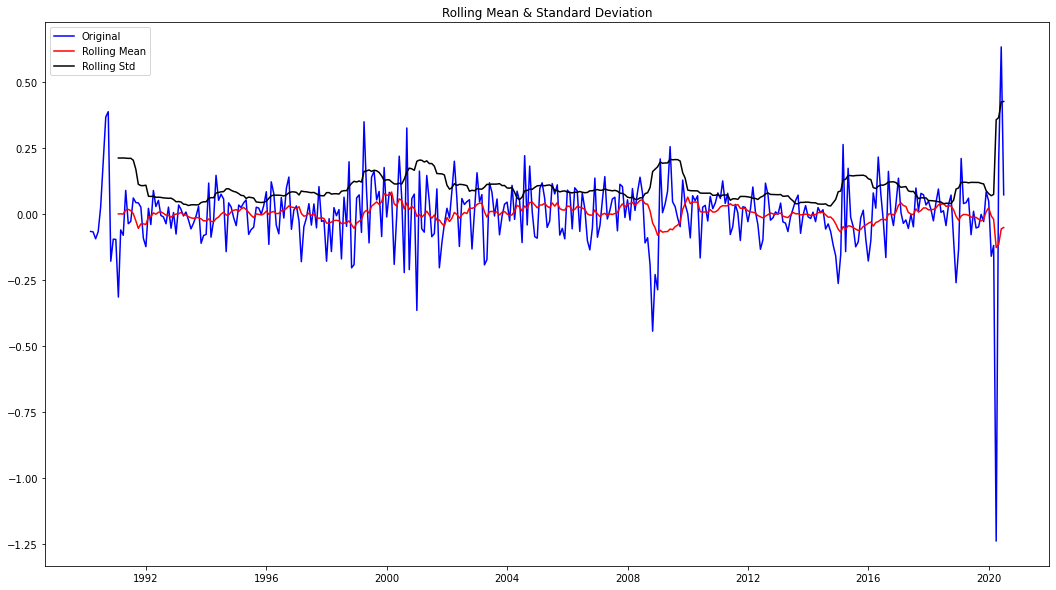

ADF Statistic: -14.151908118282376
p-value: 2.154520289606408e-26
Critical Values:
	1%: -3.448493650810824
	5%: -2.8695352280356556
	10%: -2.5710293341377715


In [18]:
test_stationarity(BRENT_log_diff)

### As we can see in the figure and Dickey Fuller test above, the transformed log differenced BRENT time series data are stationary. The rolling mean and SD are relatively constant over time, the WTI Dickey Fuller test is  < .05, and the ADF statistic is much lower than the critical values. Thus, we can reject the null hypothesis and conclude the data stationary.

# Step 3: Explore Autocorrelation Functioms (ACF) and Partial Autocorrelation Functions (PACF)

### ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

### PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

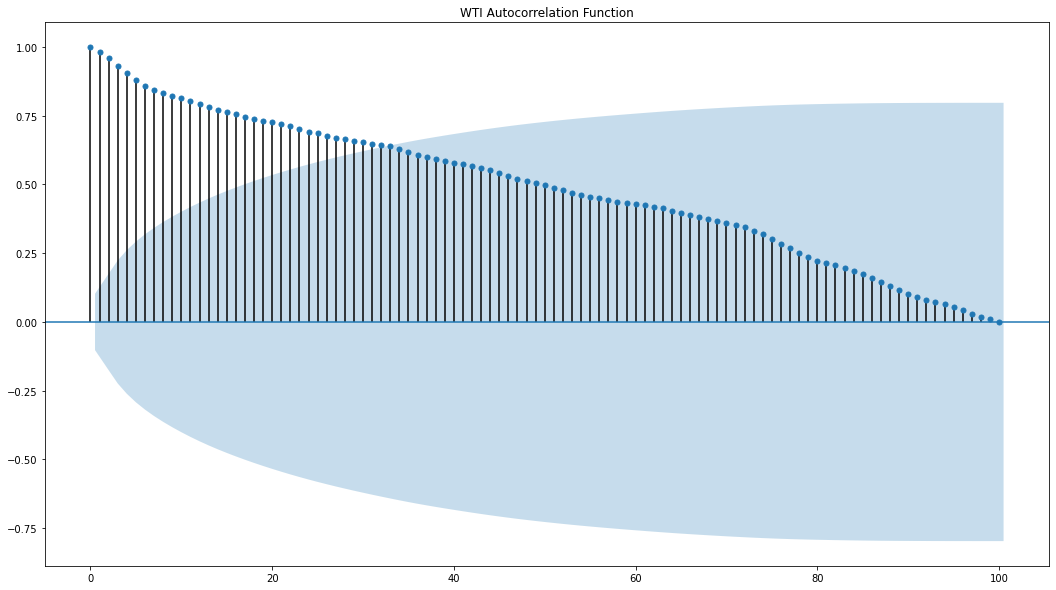

In [19]:
plot_acf(WTI_ts, lags=100)
plt.title('WTI Autocorrelation Function')
plt.show()

## From our WTI autocorrelation figure, we see that there is no indication of seasonality and a slight negative trend over time

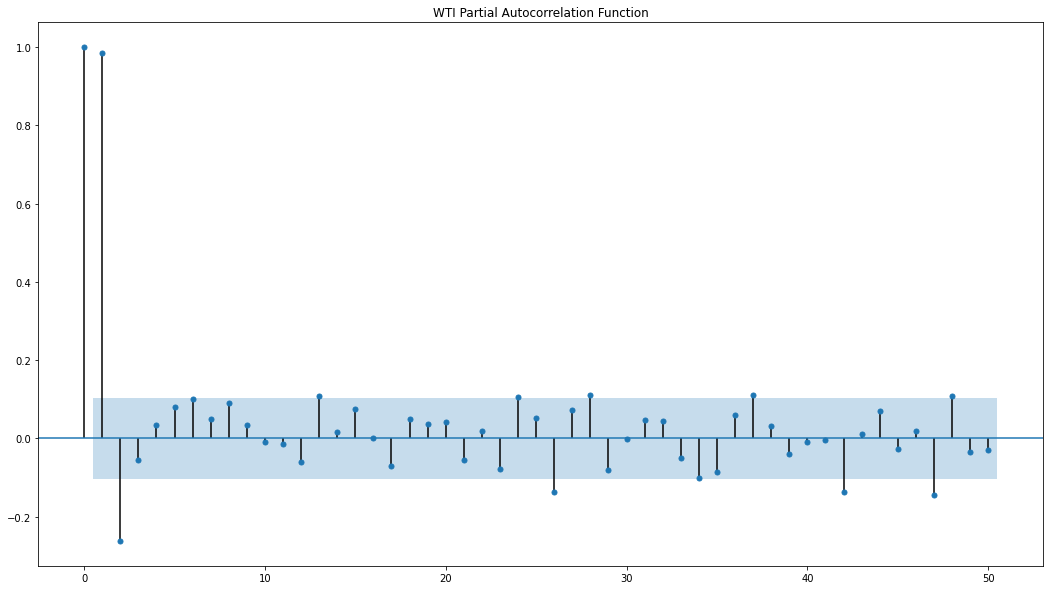

In [20]:
plot_pacf(WTI_ts, lags=50)
plt.title('WTI Partial Autocorrelation Function')
plt.show()

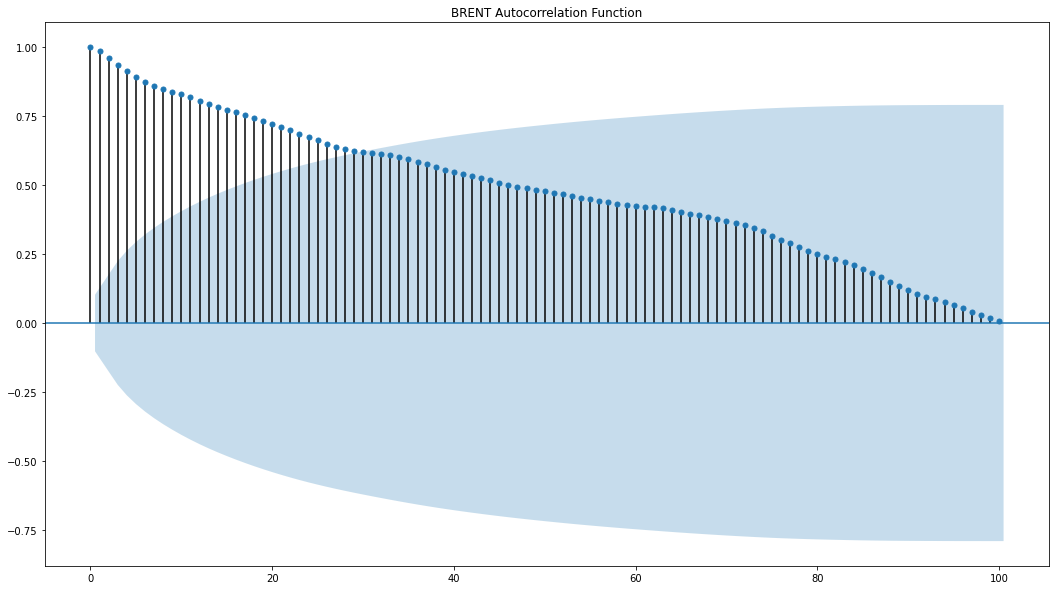

In [21]:
plot_acf(BRENT_ts, lags=100)
plt.title('BRENT Autocorrelation Function')
plt.show()

## From our BRENT autocorrelation figure, we see that there is no indication of seasonality and a slight negative trend over time

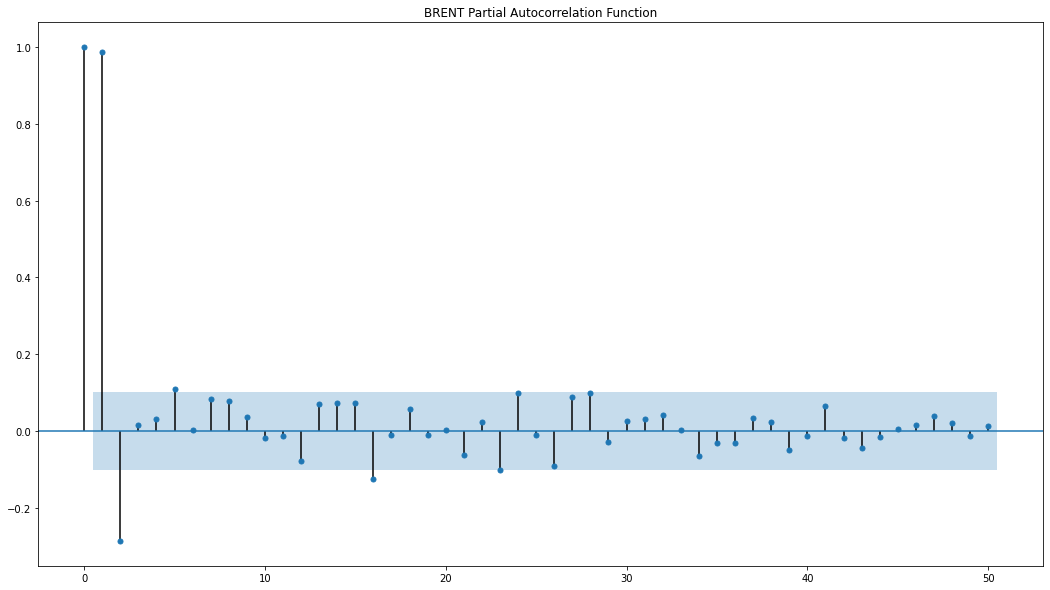

In [22]:
plot_pacf(BRENT_ts, lags=50)
plt.title('BRENT Partial Autocorrelation Function')
plt.show()

# STEP 4) Running an ARIMA model

## Step 4a) Spliting the datasets into training and test datasets 

In [23]:
split_date = pd.datetime(2019,1,1)
WTI_train = WTI_ts.loc[WTI_ts.index < split_date]
WTI_test = WTI_ts.loc[WTI_ts.index >= split_date]
BRENT_train = BRENT_ts.loc[BRENT_ts.index < split_date]
BRENT_test = BRENT_ts.loc[BRENT_ts.index >= split_date]
BRENT_train

Date
1990-01-31    20.50
1990-02-28    19.20
1990-03-31    17.95
1990-04-30    16.35
1990-05-31    15.30
              ...  
2018-08-31    76.94
2018-09-30    82.72
2018-10-31    74.84
2018-11-30    57.71
2018-12-31    50.57
Name: BRENT, Length: 348, dtype: float64

## Step 4b) Run auto-ARIMA procedure for evaluating the combinations of p, d and q values to find the best fitting ARIMA models for each oil type.
### ARIMA model paramters:
###     p: The order of the auto-regressive (AR) model (i.e., the number of lag observations)
###     d: The degree of differencing.
###     q: The order of the moving average (MA) model. The size of the “window” function over your time series data.


### Evaluating ARIMA hyperparatmers for WTI

In [24]:
WTI_arima_model =  auto_arima(WTI_train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2269.547, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2175.535, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2260.285, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2145.088, Time=0.45 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2119.952, Time=1.03 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2107.328, Time=2.13 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2087.380, Time=3.80 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=2063.849, Time=13.25 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=8.97 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=31.66 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=26.08 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=2079.024, Time=13.48 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=15.78 sec
 ARIMA(1,1,1)(5,1,1)[12]             : 

#### Results: The best fitting ARIMA model for WTI is a (1, 1, 0) model. The summary of the WTI ARIMA model details below.

In [25]:
WTI_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 0)x(5, 1, [1], 12)   Log Likelihood               -1023.924
Date:                              Sat, 21 Nov 2020   AIC                           2063.849
Time:                                      08:16:42   BIC                           2094.362
Sample:                                           0   HQIC                          2076.013
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2266      0.039      5.878      0.000       0.151       0.302
ar.S.L12      -0.1327      0.070     -1.894      0.058      -0.270       0.005
ar.S.L24      -0.1338      0.072     -1.848      0.065      -0.276       0.008
ar.S.L36      -0.1454      0.072     -2.023      0.043      -0.286      -0.005
ar.S.L48      -0.0840      0.069     -1.216      0.224      -0.219       0.051
ar.S.L60      -0.0842      0.071     -1.194      0.233      -0.222       0.054
ma.S.L12      -0.8774      0.062    -14.058      0.000      -1.000      -0.755
sigma2        24.3581      1.271     19.158      0.000      21.866      26.850
===================================================================================
Ljung-Box (Q):                       48.93   Jarque-Bera (JB):               281.77
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               8.54   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluating ARIMA hyperparatmers for BRENT

In [26]:
BRENT_arima_model =  auto_arima(BRENT_train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2287.474, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2195.064, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2270.036, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2155.596, Time=0.48 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=2139.806, Time=1.18 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=2123.867, Time=1.98 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2113.121, Time=3.53 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=17.78 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=9.23 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=2132.173, Time=3.07 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=2115.100, Time=4.24 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=2115.099, Time=5.42 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=2113.908, Time=3.91 sec
 ARIMA(2,1,1)(5,1,0)[12]         

#### Results: The best fitting ARIMA model for BRENT is a (1, 1, 0) model. The summary of the BRENT ARIMA model details below.

In [27]:
#Summary of the model
BRENT_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  348
Model:             SARIMAX(1, 1, 0)x(5, 1, 0, 12)   Log Likelihood               -1049.561
Date:                            Fri, 20 Nov 2020   AIC                           2113.121
Time:                                    20:06:43   BIC                           2139.820
Sample:                                         0   HQIC                          2123.765
                                            - 348                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2512      0.037      6.826      0.000       0.179       0.323
ar.S.L12      -0.8194      0.042    -19.727      0.000      -0.901      -0.738
ar.S.L24      -0.7013      0.056    -12.606      0.000      -0.810      -0.592
ar.S.L36      -0.5344      0.070     -7.635      0.000      -0.672      -0.397
ar.S.L48      -0.3966      0.075     -5.307      0.000      -0.543      -0.250
ar.S.L60      -0.2027      0.057     -3.537      0.000      -0.315      -0.090
sigma2        29.5927      1.722     17.189      0.000      26.218      32.967
===================================================================================
Ljung-Box (Q):                       46.19   Jarque-Bera (JB):               136.78
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               7.62   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 4c) Compare the predicted oil prices from the ARIMA models against the observed values from our test datasets to test the accuracy of our models

### Comparing the predicted WTI oil prices from our ARIMA models against the test data

In [74]:
#Obtain the ARIMA model's predicted values and 95% CI from 2019 to 2020

WTI_prediction, WTI_confint = WTI_arima_model.predict(n_periods = 18, return_conf_int=True)
WTI_prediction = pd.DataFrame(WTI_prediction,index=WTI_test.index)
WTI_prediction.columns = ['WTI_predicted_oil_price']
WTI_lower_series = pd.Series(WTI_confint[:, 0], index=WTI_test.index)
WTI_upper_series = pd.Series(WTI_confint[:, 1], index=WTI_test.index)

#Calculate the model fit and accuracy scores of ARIMA model for predicitng WTI test data from 2019 to 2020

WTI_accuracy = metrics.r2_score(WTI_test, WTI_prediction)
WTI_ARIMA_MSE = metrics.mean_squared_error(WTI_test, WTI_prediction)

WTI_ARIMA_MSE

206.87459549137685

In [72]:
#create shortened time frame for Plotly plot
import datetime
WTI_train_2 = pd.read_csv('WTI_train.csv')
fig_date = pd.datetime(2015,1,1)
WTI_train_2= pd.DataFrame(WTI_train_2)
WTI_train_2['date']  = pd.to_datetime(WTI_train_2['date'], yearfirst=True)
WTI_train_2 = WTI_train_2.loc[WTI_train_2['date'] >= fig_date]
WTI_train_2=WTI_train_2.set_index('date')
WTI_train_2

,WTI
date,
2015-01-02,52.72
2015-01-05,50.05
2015-01-06,47.98
2015-01-07,48.69
2015-01-08,48.80
...,...
2018-12-19,47.96
2018-12-20,45.64
2018-12-21,45.38


In [77]:
#Visualising the predictions and original data using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=WTI_train_2.index,
        y=WTI_train_2['WTI'], mode='lines',
        name='WTI Train'))
fig.add_trace(go.Scatter(x=WTI_test.index,
        y=WTI_test,mode='lines',
        name='"WTI Test'))
fig.add_trace(go.Scatter(x=WTI_prediction.index,
        y=WTI_prediction['WTI_predicted_oil_price'],mode='lines',
        name='WTI ARIMA Predicted'))
fig.update_layout(
    title="ARIMA  (1, 1, 0) model for WTI Monthly Oil Price Over Time: MSE = 206.87",
    xaxis_title="Year",
    yaxis_title="Price($)/Barrel")
fig.show()


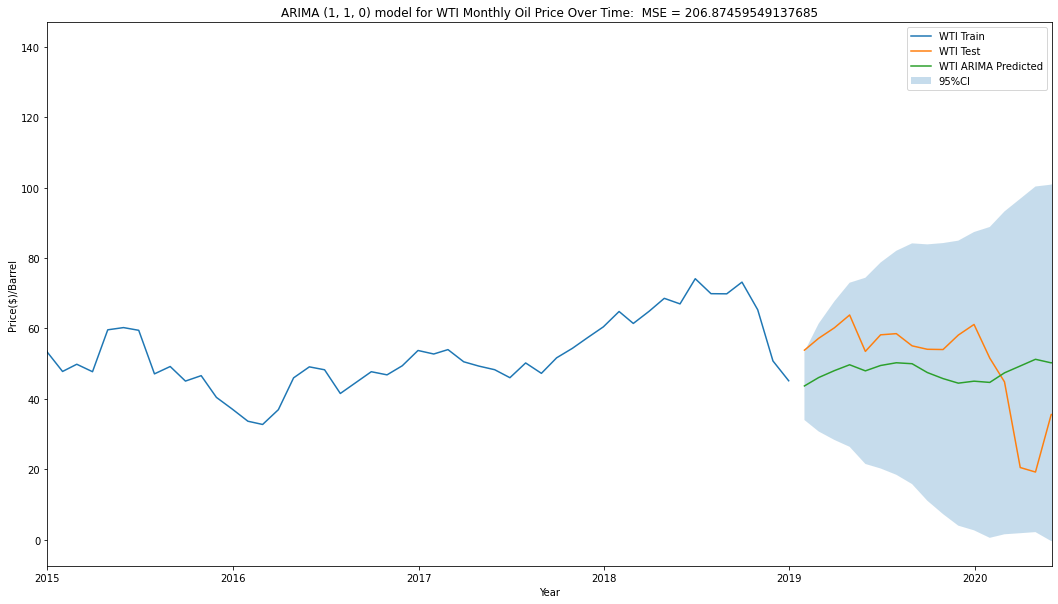

In [78]:
#Visualising the predictions and original data using Matplotlib

plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(WTI_train,label="WTI Train")
plt.plot(WTI_test,label="WTI Test")
plt.plot(WTI_prediction,label="WTI ARIMA Predicted")
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.fill_between(WTI_lower_series.index, 
                     WTI_lower_series, 
                     WTI_upper_series, 
                     alpha=0.25, label='95%CI')
plt.title(f'ARIMA (1, 1, 0) model for WTI Monthly Oil Price Over Time:  MSE = {WTI_ARIMA_MSE}')
plt.legend(loc = 'Left corner')
plt.show()

In [79]:
print(f'The Model fit for the ARIMA (1, 1, 0) model using the daily WTI oil price data is: R2 = {WTI_accuracy} and MSE = {WTI_ARIMA_MSE}')


The Model fit for the ARIMA (1, 1, 0) model using the daily WTI oil price data is: R2 = -0.23071918963708415 and MSE = 206.87459549137685


# WTI ARIMA (1, 1, 0) Time Series Model (Monthly) Conclusion:
## The ARIMA  (1, 1, 0) model using the monthly oil price data does a poor job of predicting the actual BRENT test data from 2019 to 2020. The R-squared value is negative, suggesting that the prediction tends to be less accurate than the average value of the dataset over time. However, the ARIMA model using the WTI monthly data (WTI monthly model: R2 = -0.23, MSE = 206.87) peforms slightly better than than the ARIMA (1, 1, 0) model using the WTI daily oil price data (WTI daily model: R2 = -0.19, MSE = 217.92).

### Comparing the predicted BRENT oil prices from our ARIMA models against the test data

In [80]:
#Obtain the ARIMA model's predicted values and 95% CI from 2019 to 2020

BRENT_prediction, BRENT_confint = BRENT_arima_model.predict(n_periods = 18, return_conf_int=True)
BRENT_prediction = pd.DataFrame(BRENT_prediction,index=BRENT_test.index)
BRENT_prediction.columns = ['BRENT_predicted_oil_price']
BRENT_lower_series = pd.Series(BRENT_confint[:, 0], index=WTI_test.index)
BRENT_upper_series = pd.Series(BRENT_confint[:, 1], index=WTI_test.index)

#Calculate the model fit and accuracy scores of ARIMA model for predicitng WTI test data from 2019 to 2020

BRENT_accuracy = metrics.r2_score(BRENT_test, BRENT_prediction)
BRENT_ARIMA_MSE = metrics.mean_squared_error(BRENT_test, BRENT_prediction)

In [88]:
BRENT_prediction

,BRENT_predicted_oil_price
Date,
2019-01-31,48.546590
2019-02-28,49.635050
2019-03-31,47.615683
2019-04-30,50.525300
2019-05-31,51.001004
2019-06-30,51.080499
2019-07-31,48.796830
2019-08-31,50.744665
2019-09-30,49.359795


In [83]:
#create shortened time frame for Plotly plot
BRENT_train_2 = pd.read_csv('BRENT_train.csv')
fig_date = pd.datetime(2015,1,1)
BRENT_train_2= pd.DataFrame(BRENT_train_2)
BRENT_train_2['date']  = pd.to_datetime(BRENT_train_2['date'], yearfirst=True)
BRENT_train_2 = BRENT_train_2.loc[BRENT_train_2['date'] >= fig_date]
BRENT_train_2=BRENT_train_2.set_index('date')
BRENT_train_2

,BRENT
date,
2015-01-02,55.38
2015-01-05,51.08
2015-01-06,50.12
2015-01-07,49.06
2015-01-08,49.43
...,...
2018-12-19,55.60
2018-12-20,52.84
2018-12-21,51.93


In [93]:
#Visualising the predictions and original data using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=BRENT_train_2.index,
        y=BRENT_train_2['BRENT'], mode='lines',
        name='BRENT Train'))
fig.add_trace(go.Scatter(x=BRENT_test.index,
        y=BRENT_test,mode='lines',
        name='"BRENT Test'))
fig.add_trace(go.Scatter(x=BRENT_prediction.index,
        y=BRENT_prediction['BRENT_predicted_oil_price'],mode='lines',
        name='BRENT ARIMA Predicted'))
fig.update_layout(
    title="ARIMA  (1, 1, 0) model for BRENT Monthly Oil Price Over Time: MSE = 312.67",
    xaxis_title="Year",
    yaxis_title="Price($)/Barrel")

fig.show()




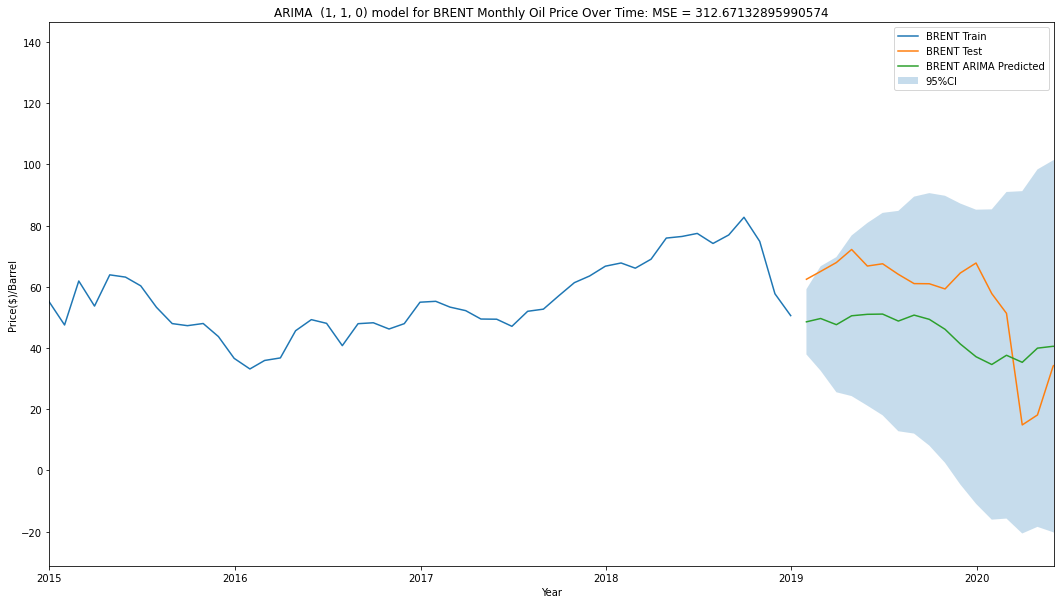

In [94]:
#Visualising the predictions and original data using Matplotlib

plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(BRENT_train,label="BRENT Train")
plt.plot(BRENT_test,label="BRENT Test")
plt.plot(BRENT_prediction,label="BRENT ARIMA Predicted")
plt.fill_between(BRENT_lower_series.index, 
                     BRENT_lower_series, 
                     BRENT_upper_series, 
                     alpha=0.25, label='95%CI')
plt.xlim([datetime.date(2015, 1, 1), datetime.date(2020, 6, 1)])
plt.title(f'ARIMA  (1, 1, 0) model for BRENT Monthly Oil Price Over Time: MSE = {BRENT_ARIMA_MSE}')
plt.legend(loc = 'Left corner')
plt.show()

In [95]:
print(f'The Model fit for the BRENT ARIMA  (1, 1, 0) model using the daily oil price data is: R2 = {BRENT_accuracy} and MSE = {BRENT_ARIMA_MSE}')


The Model fit for the BRENT ARIMA  (1, 1, 0) model using the daily oil price data is: R2 = -0.10292401360873082 and MSE = 312.67132895990574


# BRENT ARIMA (1, 1, 0) Time Series Model (Monthly) Conclusion:
## The ARIMA  (1, 1, 0) model using the monthly oil price data does a poor job of predicting the actual BRENT test data from 2019 to 2020. The R-squared value is negative, suggesting that the prediction tends to be less accurate than the average value of the dataset over time. However, the ARIMA model using the BRENT monthly data (BRENT monthly model: R2 = -0.10, MSE = 312.67) peforms  slightly worse than than the ARIMA (1, 1, 0) model using the BRENT daily oil price data (BRENT daily model: R2 = -0.20, MSE = 276.87).